In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns',0)

/tmp/ipykernel_10760/3884596303.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
df=pd.read_csv('yellow_tripdata_2023-01.csv',low_memory=False)

In [6]:
df.sample(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1581671,2,2023-01-17 23:38:50,2023-01-17 23:41:16,1.0,0.65,1.0,N,141,237,2,5.1,1.0,0.5,0.0,0.0,1.0,10.1,2.5,0.0
3010183,1,2023-01-07 20:57:51,2023-01-07 21:13:24,NaN,1.9,NaN,NaN,113,170,0,13.5,1.0,0.5,3.7,0.0,1.0,22.2,NaN,NaN
2501380,1,2023-01-26 22:06:05,2023-01-26 22:16:05,1.0,1.9,1.0,N,246,107,3,10.7,3.5,0.5,0.0,0.0,1.0,15.7,2.5,0.0


In [7]:
#total number of rows and column (3066812, 19)
df.shape

(3066812, 19)

In [8]:
#Check null value in all column
df.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
dtype: int64

In [9]:
#Check distinct value in PULocationID and DOLocationID column
print(df['passenger_count'].isnull().sum())

71743


## passenger_count, RatecodeID, store_and_fwd_flag, congestion_surcharge and airport_fee column has 71743 records of null value.

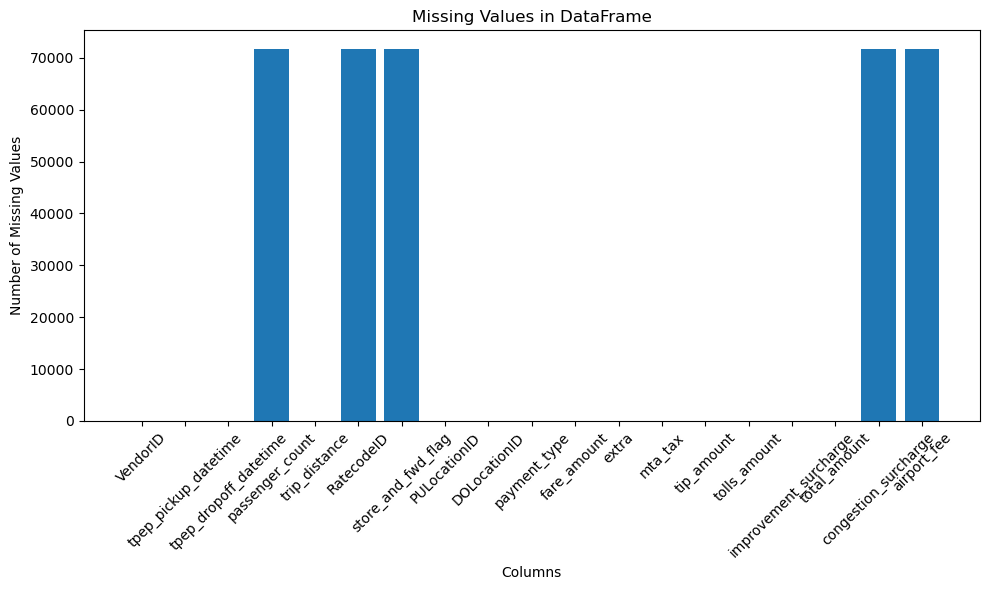

In [10]:
#Plot null value count with column

# Assuming df is your DataFrame
missing_values = df.isnull().sum()

# Creating a bar plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(missing_values.index, missing_values.values)
plt.title('Missing Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [11]:
#Check the data types of all present column in df dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066812 entries, 0 to 3066811
Data columns (total 19 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   VendorID               object
 1   tpep_pickup_datetime   object
 2   tpep_dropoff_datetime  object
 3   passenger_count        object
 4   trip_distance          object
 5   RatecodeID             object
 6   store_and_fwd_flag     object
 7   PULocationID           object
 8   DOLocationID           object
 9   payment_type           object
 10  fare_amount            object
 11  extra                  object
 12  mta_tax                object
 13  tip_amount             object
 14  tolls_amount           object
 15  improvement_surcharge  object
 16  total_amount           object
 17  congestion_surcharge   object
 18  airport_fee            object
dtypes: object(19)
memory usage: 444.6+ MB


In [12]:
distinct_count = len(df['VendorID'].unique())
print("Distinct value in VendorID column",df['VendorID'].unique())
print("Count of distinct values in 'VendorID' column:", distinct_count)

Distinct value in VendorID column ['2' '1' 'VendorID']
Count of distinct values in 'VendorID' column: 3


### For data better understanding let's load the both csv file in postgresql database but this is completely optional we can do all the data preparation part using pandas.

In [15]:
import psycopg2
import pandas as pd
from psycopg2 import extras

try:
    # Establishing the connection
    conn = psycopg2.connect(
        database="postgres", user='postgres', password='password', host='127.0.0.1', port='5432')
    
    # Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    
    # Create table yellow_tripdata_2023_01 if not exists
    cursor.execute('''CREATE TABLE IF NOT EXISTS yellow_tripdata_2023_01 (
                            id SERIAL PRIMARY KEY,
                            VendorID TEXT, 
                            tpep_pickup_datetime TEXT,
                            tpep_dropoff_datetime TEXT,
                            passenger_count TEXT,
                            trip_distance TEXT,
                            RatecodeID TEXT,
                            store_and_fwd_flag TEXT,
                            PULocationID TEXT,
                            DOLocationID TEXT,
                            payment_type TEXT,
                            fare_amount TEXT,
                            extra TEXT,
                            mta_tax TEXT,
                            tip_amount TEXT,
                            tolls_amount TEXT,
                            improvement_surcharge TEXT,
                            total_amount TEXT,
                            congestion_surcharge TEXT,
                            airport_fee TEXT);''')
    
    # Commit the table creation
    conn.commit()
    print("Table 'yellow_tripdata_2023_01' created successfully")
    
    # Load CSV file into a DataFrame skipping the header row
    df = pd.read_csv('yellow_tripdata_2023-01.csv', low_memory=False) 
    
    # Prepare data as a list of tuples
    data = [tuple(row) for row in df.itertuples(index=False, name=None)]
    
    # Construct the INSERT INTO statement
    insert_query = """
        INSERT INTO yellow_tripdata_2023_01 (VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, 
        trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, 
        mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee)
        VALUES %s
    """
    
    # Execute the INSERT INTO statement using execute_values()
    extras.execute_values(cursor, insert_query, data, page_size=100000) #page_size is number of rows to be inserted  
    
    # Committing the transaction
    conn.commit()
    print("Data inserted successfully in yellow_tripdata_2023_01 table")
    
    
    # Create table taxi_zones if not exists
    cursor.execute('''create table taxi_zones(OBJECTID int PRIMARY KEY,
                                                    Shape_Leng float,
                                                    the_geom text,
                                                    Shape_Area float,
                                                    Zone text,
                                                    LocationID int,
                                                    Borough text);''')
    

    # Commit the table creation
    conn.commit()
    
    print("Table 'taxi_zones' created successfully")

    # Load CSV file into a DataFrame skipping the header row
    zone_df = pd.read_csv('/home/bibek/Desktop/uber_data_engineering/data/taxi_zones.csv', low_memory=False) 
    
    # Prepare data as a list of tuples
    zone_data = [tuple(row) for row in zone_df.itertuples(index=False, name=None)]
    
    # Construct the INSERT INTO statement
    zone_insert_query = """
        INSERT INTO taxi_zones (OBJECTID,Shape_Leng,the_geom,Shape_Area,Zone,LocationID,Borough)
        VALUES %s
    """
    
    # Execute the INSERT INTO statement using execute_values()
    extras.execute_values(cursor, zone_insert_query, zone_data, page_size=1000) #page_size is number of rows to be inserted  
    
    # Committing the transaction
    conn.commit()
    print("Data inserted successfully in taxi_zones table")

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL or inserting data:", error)

finally:
    # Closing the connection
    if conn:
        cursor.close()
        conn.close()
        print("PostgreSQL connection is closed")

Table 'yellow_tripdata_2023_01' created successfully
Data inserted successfully in yellow_tripdata_2023_01 table
Table 'taxi_zones' created successfully
Data inserted successfully in taxi_zones table
PostgreSQL connection is closed


In [13]:
from IPython.display import Image

# Use the raw URL of the image
image_url = "https://raw.githubusercontent.com/bibek376/Uber_Data_Engineering_Project/master/pictures/1.png"

# Display the image
Image(url=image_url)


In [14]:
#only garbage data
filtered_df = df[df['VendorID'] == 'VendorID']

In [15]:
#verify them by selecting random value
filtered_df.sample(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
800027,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1000034,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1733393,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1266710,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
3000104,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee


In [16]:
#calculate total number of garabge rows in csv file
filtered_df.shape

(46, 19)

In [17]:
#Select only the proper data
after_filtered_df=df[df['VendorID'] != 'VendorID']

#### According to data dictionary VendorID, RatecodeID, store_and_fwd_flag and payment_type are the categorical data

In [18]:
after_filtered_df['VendorID']=after_filtered_df['VendorID'].astype('category')
after_filtered_df['tpep_pickup_datetime']=pd.to_datetime(after_filtered_df['tpep_pickup_datetime'])
after_filtered_df['tpep_dropoff_datetime']=pd.to_datetime(after_filtered_df['tpep_dropoff_datetime'])
after_filtered_df['passenger_count']=pd.to_numeric(after_filtered_df['passenger_count'],downcast='integer')
after_filtered_df['trip_distance']=pd.to_numeric(after_filtered_df['trip_distance'])
after_filtered_df['RatecodeID']=after_filtered_df['RatecodeID'].astype('category')
after_filtered_df['store_and_fwd_flag']=after_filtered_df['store_and_fwd_flag'].astype('category')
after_filtered_df['PULocationID']=pd.to_numeric(after_filtered_df['PULocationID'])
after_filtered_df['DOLocationID']=pd.to_numeric(after_filtered_df['DOLocationID'])
after_filtered_df['payment_type']=after_filtered_df['payment_type'].astype('category')
after_filtered_df['fare_amount']=pd.to_numeric(after_filtered_df['fare_amount'])
after_filtered_df['extra']=pd.to_numeric(after_filtered_df['extra'])
after_filtered_df['mta_tax']=pd.to_numeric(after_filtered_df['mta_tax'])
after_filtered_df['tip_amount']=pd.to_numeric(after_filtered_df['tip_amount'])
after_filtered_df['tolls_amount']=pd.to_numeric(after_filtered_df['tolls_amount'])
after_filtered_df['improvement_surcharge']=pd.to_numeric(after_filtered_df['improvement_surcharge'])
after_filtered_df['total_amount']=pd.to_numeric(after_filtered_df['total_amount'])
after_filtered_df['congestion_surcharge']=pd.to_numeric(after_filtered_df['congestion_surcharge'])
after_filtered_df['airport_fee']=pd.to_numeric(after_filtered_df['airport_fee'])

In [19]:
#Check data type conversion
after_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3066766 entries, 0 to 3066811
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               category      
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             category      
 6   store_and_fwd_flag     category      
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           category      
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            floa

### check if there is same value in tpep_pickup_datetime and tpep_dropoff_datetime: if there is same value logically data is not useful

In [20]:
same_values=after_filtered_df['tpep_pickup_datetime'] == after_filtered_df['tpep_dropoff_datetime']
same_values_df = after_filtered_df[same_values]
print("Number of rows where tpep_pickup_datetime and tpep_dropoff_datetime is same",same_values_df.shape[0])
same_values_df.sample(4)

Number of rows where tpep_pickup_datetime and tpep_dropoff_datetime is same 1118


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1845643,1,2023-01-20 14:14:53,2023-01-20 14:14:53,1.0,0.0,2.0,N,132,264,2,70.00,2.5,0.5,0.0,0.0,1.0,74.00,0.0,1.25
2245084,1,2023-01-24 16:50:50,2023-01-24 16:50:50,0.0,0.0,99.0,N,264,264,1,20.00,0.0,0.0,0.0,0.0,0.0,20.00,0.0,0.00
2509269,1,2023-01-26 23:04:05,2023-01-26 23:04:05,0.0,0.0,1.0,Y,100,264,2,9.30,3.5,0.5,0.0,0.0,1.0,14.30,2.5,0.00
1104673,1,2023-01-13 08:59:23,2023-01-13 08:59:23,0.0,0.0,99.0,Y,263,264,1,51.92,0.0,0.0,0.0,0.0,0.0,51.92,0.0,0.00


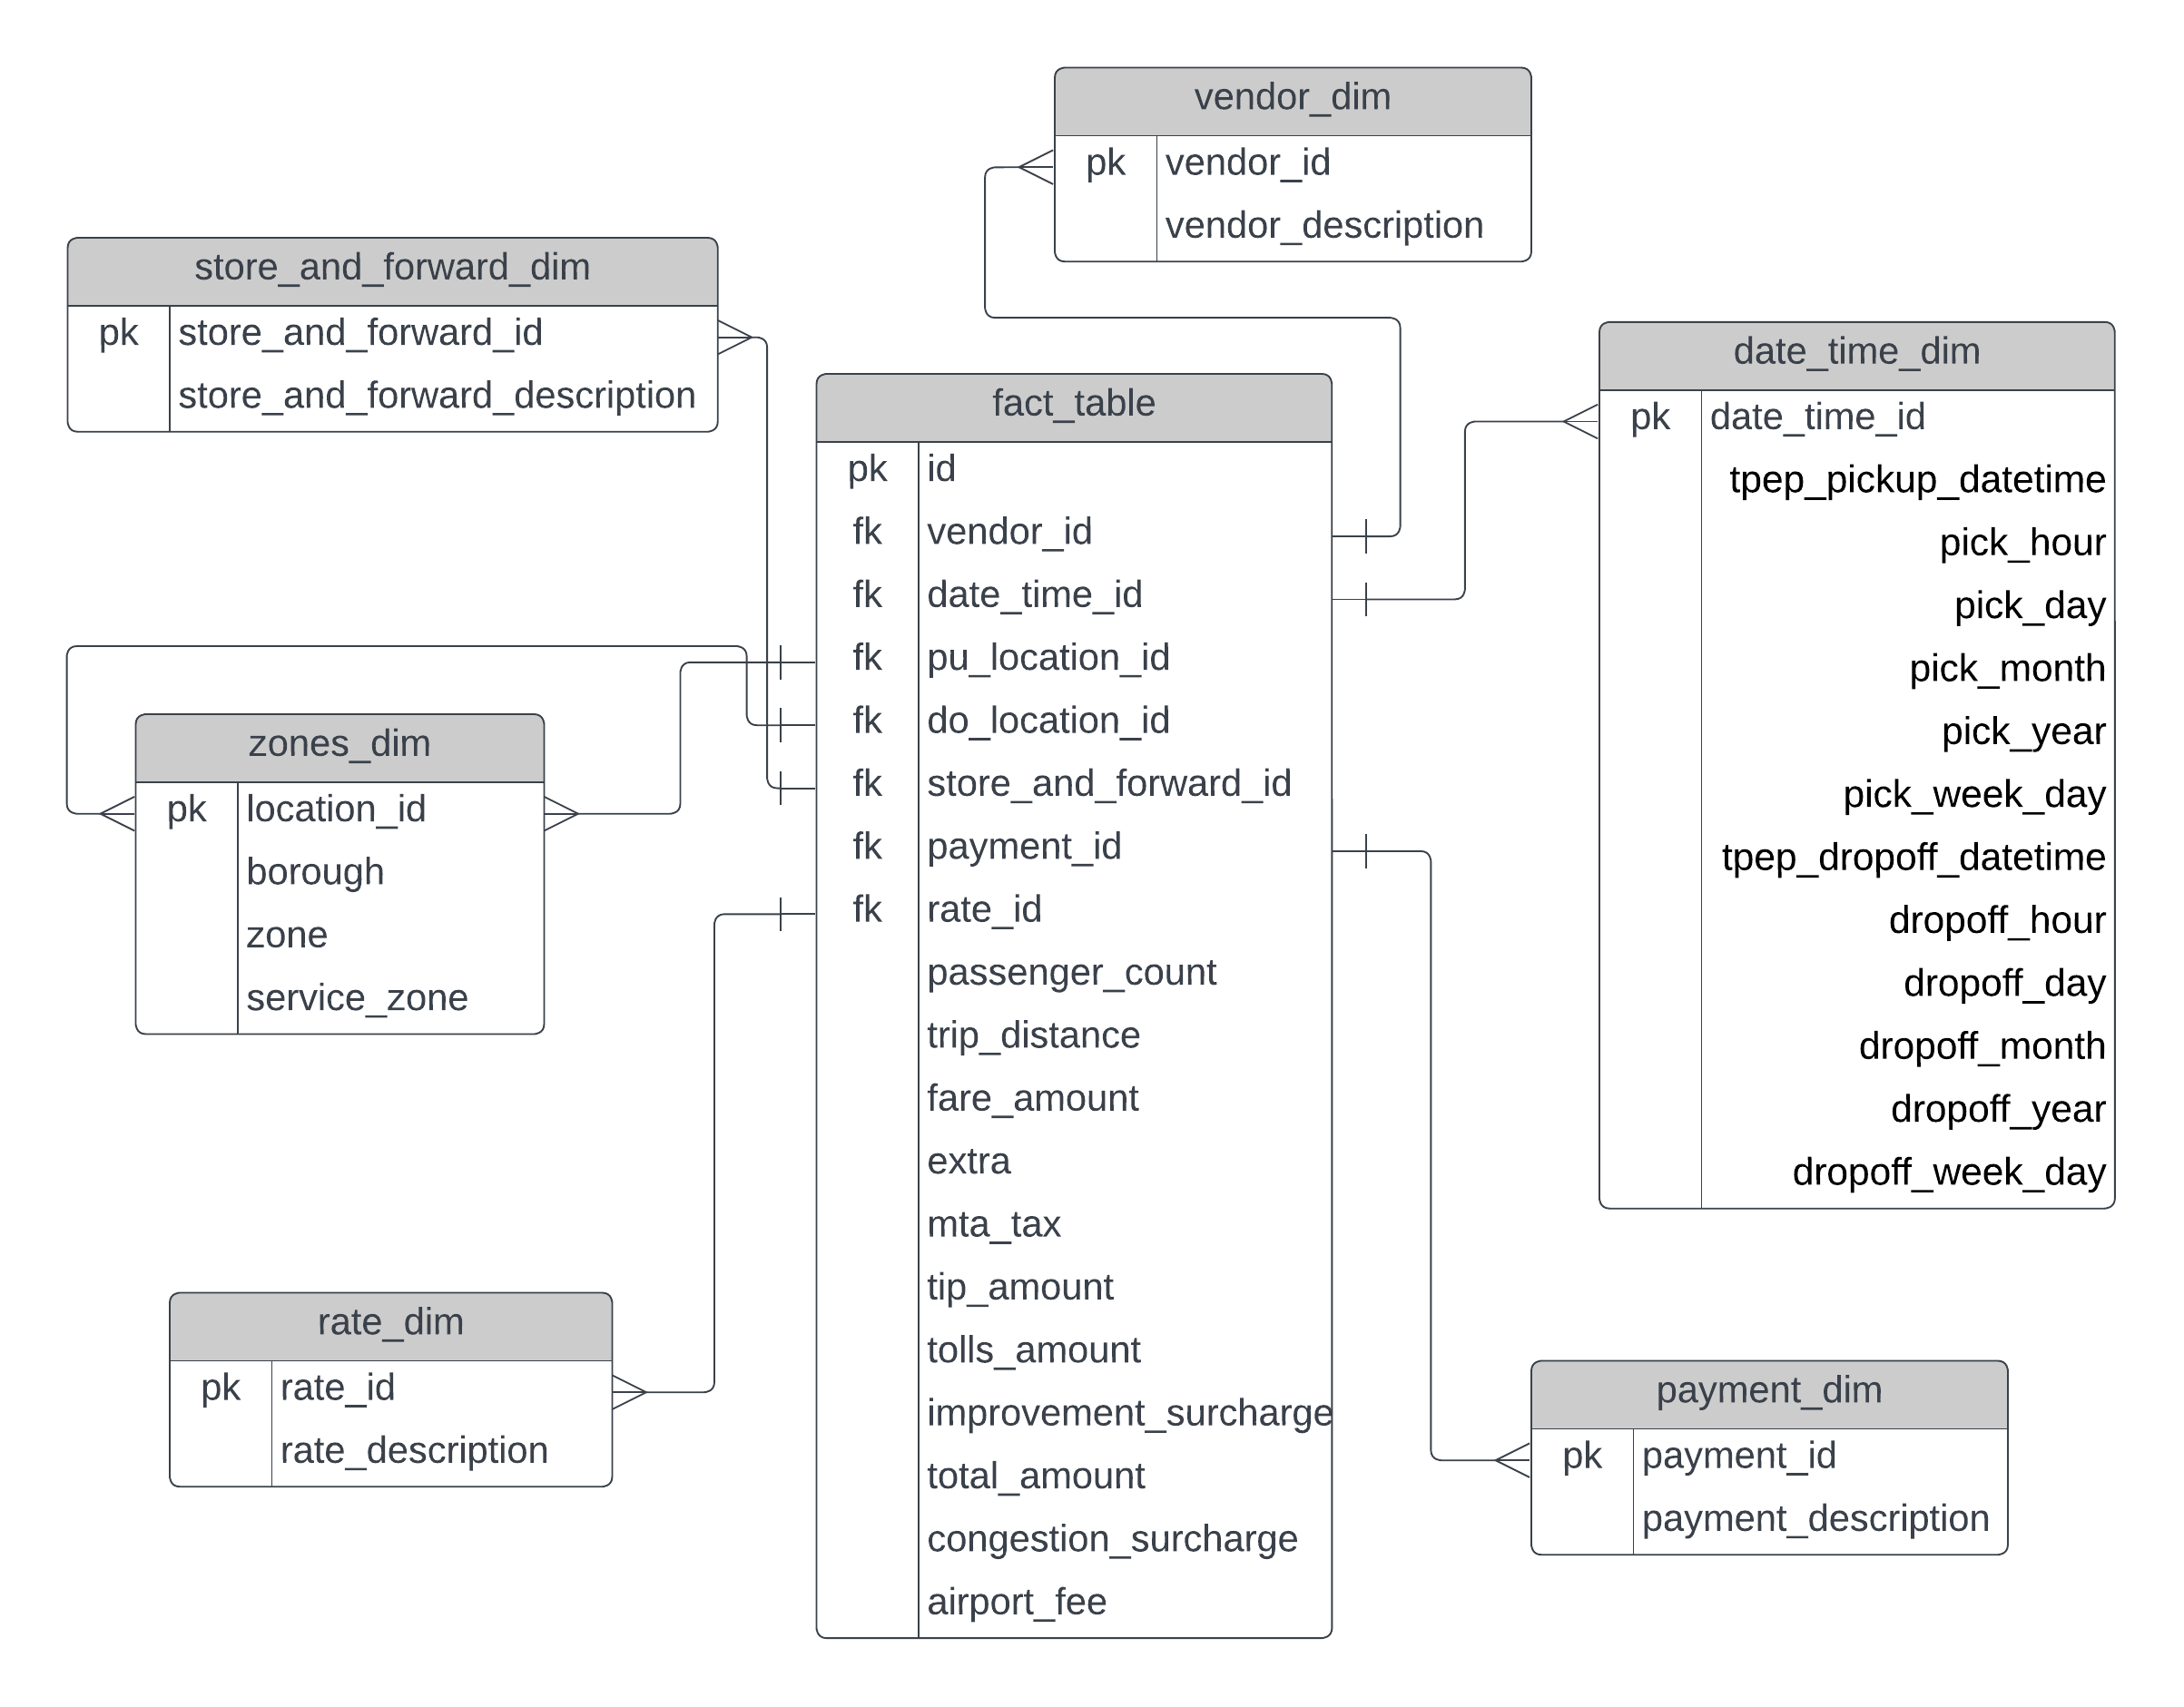

In [22]:
from IPython import display
display.Image("/home/bibek/Desktop/uber_data_engineering/pictures/2.png")

### According to ER diagram now we have to create date and time dimension table where data can be identified on the basis of month, day and year. 

In [23]:
### Extract the year, month, day, weekday and hour data using tpep_pickup_datetime and tpep_dropoff_datetime
after_filtered_df['pickup_year'] = after_filtered_df['tpep_pickup_datetime'].dt.year
after_filtered_df['pickup_month'] = after_filtered_df['tpep_pickup_datetime'].dt.month
after_filtered_df['pickup_day'] = after_filtered_df['tpep_pickup_datetime'].dt.day
after_filtered_df['pickup_weekday'] = after_filtered_df['tpep_pickup_datetime'].dt.weekday
after_filtered_df['pickup_hour'] = after_filtered_df['tpep_pickup_datetime'].dt.hour
after_filtered_df['dropoff_year'] = after_filtered_df['tpep_dropoff_datetime'].dt.year
after_filtered_df['dropoff_month'] = after_filtered_df['tpep_dropoff_datetime'].dt.month
after_filtered_df['dropoff_day'] = after_filtered_df['tpep_dropoff_datetime'].dt.day
after_filtered_df['dropoff_weekday'] = after_filtered_df['tpep_dropoff_datetime'].dt.weekday
after_filtered_df['dropoff_hour'] = after_filtered_df['tpep_dropoff_datetime'].dt.hour

In [24]:
after_filtered_df.sample(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
2179861,2,2023-01-23 20:54:23,2023-01-23 21:01:57,2.0,0.89,1.0,N,114,232,1,8.6,1.0,0.5,2.72,0.0,1.0,16.32,2.5,0.0,2023,1,23,0,20,2023,1,23,0,21
1209738,2,2023-01-14 01:45:01,2023-01-14 01:48:54,1.0,0.72,1.0,N,234,137,2,6.5,1.0,0.5,0.00,0.0,1.0,11.50,2.5,0.0,2023,1,14,5,1,2023,1,14,5,1
1737793,2,2023-01-19 14:49:43,2023-01-19 14:54:48,1.0,0.54,1.0,N,163,142,1,6.5,0.0,0.5,3.00,0.0,1.0,13.50,2.5,0.0,2023,1,19,3,14,2023,1,19,3,14


In [25]:
#if tpep_pickup_datetime and tpep_dropoff_datetime is same logically it is not possible
after_duplicate_filtered_df=after_filtered_df['tpep_pickup_datetime'] != after_filtered_df['tpep_dropoff_datetime']
after_duplicate_filtered_df = after_filtered_df[after_duplicate_filtered_df]
after_duplicate_filtered_df.sample(4)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
756390,2,2023-01-09 17:19:47,2023-01-09 17:27:03,2.0,1.31,1.0,N,170,234,1,8.6,2.5,0.5,3.02,0.00,1.0,18.12,2.5,0.00,2023,1,9,0,17,2023,1,9,0,17
777373,2,2023-01-09 21:34:51,2023-01-09 22:01:08,1.0,5.94,1.0,N,68,97,1,30.3,1.0,0.5,7.06,0.00,1.0,42.36,2.5,0.00,2023,1,9,0,21,2023,1,9,0,22
1617275,2,2023-01-18 12:19:19,2023-01-18 12:37:54,2.0,8.69,1.0,N,138,262,1,35.9,5.0,0.5,13.18,6.55,1.0,65.88,2.5,1.25,2023,1,18,2,12,2023,1,18,2,12
2725971,2,2023-01-28 23:07:03,2023-01-28 23:11:17,1.0,0.70,1.0,N,170,233,1,6.5,1.0,0.5,2.30,0.00,1.0,13.80,2.5,0.00,2023,1,28,5,23,2023,1,28,5,23


In [26]:
print("Initial number of row count in yellow_tripdata_2023-01.csv file",df.shape[0], "and column is ",df.shape[1])
print("After Deleting garbage value row count is ",after_filtered_df.shape[0], 
      "and column is",after_filtered_df.shape[1])
print("Number of rows where tpep_pickup_datetime and tpep_dropoff_datetime is same",same_values_df.shape[0])
print("Number of rows after drop same value",after_duplicate_filtered_df.shape[0])

print("Number of Rows after data cleaning process",df.shape[0]-46-same_values_df.shape[0])

Initial number of row count in yellow_tripdata_2023-01.csv file 3066812 and column is  19
After Deleting garbage value row count is  3066766 and column is 29
Number of rows where tpep_pickup_datetime and tpep_dropoff_datetime is same 1118
Number of rows after drop same value 3065648
Number of Rows after data cleaning process 3065648


### let's explore taxi+_zone_lookup.csv file

In [27]:
df_taxi_zone=pd.read_csv('/home/bibek/Desktop/uber_data_engineering/data/taxi_zones.csv')
df_taxi_zone.sample(3)

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
165,165,0.088608,MULTIPOLYGON (((-73.96014773499996 40.62891518...,0.000354,Midwood,165,Brooklyn
231,239,0.063626,MULTIPOLYGON (((-73.97501417199996 40.78768560...,0.000205,Upper West Side South,239,Manhattan
262,262,0.049064,MULTIPOLYGON (((-73.94383256699986 40.78285908...,0.000122,Yorkville East,262,Manhattan


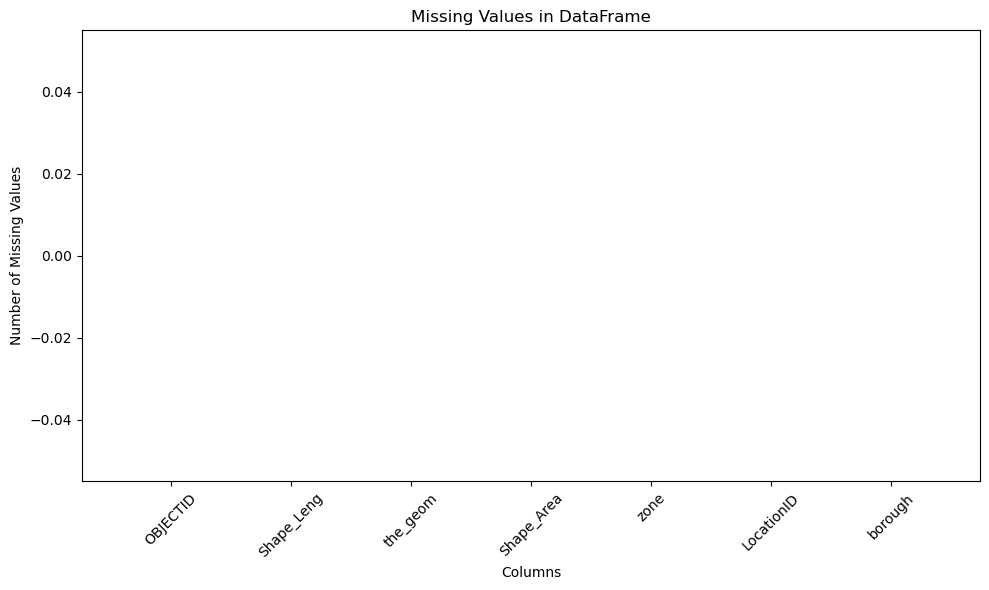

In [28]:
# Assuming df is your DataFrame
missing_values = df_taxi_zone.isnull().sum()

# Creating a bar plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(missing_values.index, missing_values.values)
plt.title('Missing Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [29]:
#dataset is fine and no need to do anything 
df_taxi_zone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OBJECTID    263 non-null    int64  
 1   Shape_Leng  263 non-null    float64
 2   the_geom    263 non-null    object 
 3   Shape_Area  263 non-null    float64
 4   zone        263 non-null    object 
 5   LocationID  263 non-null    int64  
 6   borough     263 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 14.5+ KB


In [30]:
after_duplicate_filtered_df.head(8).reset_index(drop=True)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,2023,1,1,6,0,2023,1,1,6,1
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,2023,1,1,6,0,2023,1,1,6,0
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0
5,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,12.8,1.00,0.5,10.00,0.0,1.0,27.80,2.5,0.00,2023,1,1,6,0,2023,1,1,6,1
6,2,2023-01-01 00:09:22,2023-01-01 00:19:49,1.0,1.66,1.0,N,239,143,1,12.1,1.00,0.5,3.42,0.0,1.0,20.52,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0
7,2,2023-01-01 00:27:12,2023-01-01 00:49:56,1.0,11.70,1.0,N,142,200,1,45.7,1.00,0.5,10.74,3.0,1.0,64.44,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0


### Create all table using data warehouse ER diagram

In [31]:
#prepare data for date_time_dim table
date_time_dim=after_duplicate_filtered_df[['tpep_pickup_datetime','pickup_year','pickup_month',
               'pickup_day','pickup_weekday','pickup_hour','tpep_dropoff_datetime',
              'dropoff_year','dropoff_month','dropoff_day','dropoff_weekday','dropoff_hour']]

In [32]:
date_time_dim.sample(2).reset_index(drop=True)

,tpep_pickup_datetime,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,tpep_dropoff_datetime,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
0,2023-01-04 17:09:19,2023,1,4,2,17,2023-01-04 17:43:45,2023,1,4,2,17
1,2023-01-18 10:55:52,2023,1,18,2,10,2023-01-18 11:02:02,2023,1,18,2,11


### VendorID - A code indicating the TPEP provider that provided the record.
#### 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.

In [ ]:
# #prepare data for vendor_dim table
# vendor_mode={
#     1:"Creative Mobile Technologies, LLC",
#     2:"VeriFone Inc."
# }
# after_duplicate_filtered_df['vendor_description']=after_duplicate_filtered_df['VendorID'].map(vendor_mode)
# vendor_dim=after_duplicate_filtered_df[['VendorID','vendor_description']]